In [8]:
import pandas as pd

In [9]:
import dpkt
import os
import pandas as pd
from utils.util import create_directory_if_not_exists, find_files_with_extension
from utils.plotter import plot_siftr_graph


# Convert bytes to Mbit/s
def bytes_to_mbits(bytes):
    return (bytes * 8) / 1_000_000

# Read pcap file and get throughput per second for specific ports
def read_pcap(file_path):
    ports = [5101, 5102, 5103, 5106, 8082]
    throughput_per_second = {port: {} for port in ports}
    goodput_per_second = {port: {} for port in ports}
    total_throughput = {port: 0 for port in ports}
    total_goodput = {port: 0 for port in ports}

    start_time = None

    with open(file_path, 'rb') as f:
        pcap = dpkt.pcap.Reader(f)

        for timestamp, buf in pcap:
            eth = dpkt.ethernet.Ethernet(buf)
            if not isinstance(eth.data, dpkt.ip.IP):
                continue

            ip = eth.data
            l4 = ip.data  # TCP or UDP

            if isinstance(l4, (dpkt.tcp.TCP, dpkt.udp.UDP)):
                dest_port = l4.dport
                if dest_port not in throughput_per_second:
                    continue

                pkt_length = len(buf)
                l4_hdr_len = 0

                # Estimate L4 header length
                if isinstance(l4, dpkt.tcp.TCP):
                    l4_hdr_len = (l4.off * 4)  # TCP offset is in 32-bit words
                elif isinstance(l4, dpkt.udp.UDP):
                    l4_hdr_len = 8  # UDP header is fixed at 8 bytes

                app_payload_len = len(l4.data)

                if start_time is None:
                    start_time = timestamp

                normalized_time = int(timestamp - start_time)

                # Throughput (includes headers)
                if normalized_time not in throughput_per_second[dest_port]:
                    throughput_per_second[dest_port][normalized_time] = pkt_length
                else:
                    throughput_per_second[dest_port][normalized_time] += pkt_length

                # Goodput (payload only)
                if normalized_time not in goodput_per_second[dest_port]:
                    goodput_per_second[dest_port][normalized_time] = app_payload_len
                else:
                    goodput_per_second[dest_port][normalized_time] += app_payload_len

                total_throughput[dest_port] += pkt_length
                total_goodput[dest_port] += app_payload_len

    return throughput_per_second, goodput_per_second, total_throughput, total_goodput


# Plot throughput using plot_siftr_graph
def plot_throughput_with_siftr(file_path, ycolumn, title, xlabel, ylabel, filename, graph_directory, use_goodput=False):
    throughput, goodput, total_thrpt, total_goodpt = read_pcap(file_path)

    
    data_source = goodput if use_goodput else throughput
    total_source = total_goodpt if use_goodput else total_thrpt

    print(total_source.items())

    paths = {}
    print(f"Total {'goodput' if use_goodput else 'throughput'} for {filename}: {total_source}")
    print(data_source.items())

    for port, data in data_source.items():
        if port not in [5102, 5106]:
            continue
        sorted_data = sorted(data.items())
        times = [item[0] for item in sorted_data]
        mbits_transferred = [bytes_to_mbits(item[1]) for item in sorted_data]

        path_df = pd.DataFrame({'Time': times, ycolumn: mbits_transferred})
        path_label = f"Port {port}"
        if port == 5106:
            path_label = "UDP-Prague"
        if port == 5102:
            path_label = "Cubic"

        paths[path_label] = path_df

    # path_df.to_csv("temp_hrpt.csv", index=False)   

    paths['UDP-Prague'].to_csv("./graph_data/udp_prague_thrpt.csv")
    paths['Cubic'].to_csv("./graph_data/cubic_thrpt.csv")

    create_directory_if_not_exists(graph_directory)
    filename = str("Thrpt_UDPPraguevsCubic")
    plot_siftr_graph(paths, ycolumn, title, xlabel, ylabel, filename, graph_directory)


# Main execution

mainpth="../data/udp_net_2025-08-07-14-51-01_best"
# mainpth="../data/udp_net_2025-06-04-07-56-54"

graph_directory = os.path.join("./", "Graphs")
create_directory_if_not_exists(graph_directory)

folderpath = os.path.join(mainpth, "")

# Use the new find_files_with_extension function
filenames, filepaths, file_dict = find_files_with_extension(paths=[folderpath], extension='.pcap')

from utils.thrpt_util import analysis_pcap_tcp

Directory already exists: ./Graphs


In [10]:
# # Plot throughput for each pcap file
# for filename, filepath in zip(filenames, filepaths):
#     print(filename)
#     analysis_pcap_tcp(filepath)

In [11]:
filepaths

['../data/udp_net_2025-08-07-14-51-01_best\\pcap_server_iperf3_d1800.pcap']

dict_items([(5101, 0), (5102, 2624193268), (5103, 0), (5106, 1638181468), (8082, 0)])
Total throughput for pcap_server_iperf3_d1800.pcap_throughput: {5101: 0, 5102: 2624193268, 5103: 0, 5106: 1638181468, 8082: 0}
dict_items([(5101, {}), (5102, {0: 22688026, 1: 22672478, 2: 21476896, 3: 18645908, 4: 17585584, 5: 16404418, 6: 17351590, 7: 16502376, 8: 18295526, 9: 17933322, 10: 15045110, 11: 16298316, 12: 16534852, 13: 18393138, 14: 28184388, 15: 37173682, 16: 37962526, 17: 37254492, 18: 34238162, 19: 21875508, 20: 33785248, 21: 29784052, 22: 32994388, 23: 31448902, 24: 30400754, 25: 30577704, 26: 32916494, 27: 32397724, 28: 32671094, 29: 30742920, 30: 30680152, 31: 30366106, 32: 31116526, 33: 30525388, 34: 31159286, 35: 30687242, 36: 29381788, 37: 30460186, 38: 27851956, 39: 29212220, 40: 28327452, 41: 28764226, 42: 26573298, 43: 26679610, 44: 23798786, 45: 29000912, 46: 35567260, 47: 28337838, 48: 24062852, 49: 12079502, 50: 13458590, 51: 13480380, 52: 13169234, 53: 12765150, 54: 12128

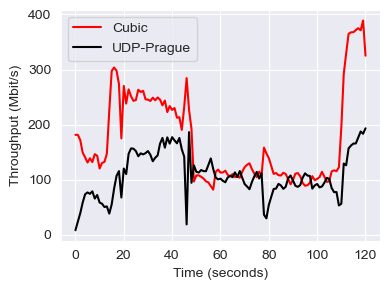

In [12]:
# Plot throughput for each pcap file
for filename, filepath in zip(filenames, filepaths):
    plot_throughput_with_siftr(
        file_path=filepath,
        ycolumn="Throughput (Mbit/s)",
        title=f"Throughput for {filename}",
        xlabel="Time (seconds)",
        ylabel="Throughput (Mbit/s)",
        filename=f"{filename}_throughput",
        graph_directory=graph_directory
    )